# Query house matched preference

Assumpt the user has completed several turns of chat with chatbot, and we already get the preference of user.

embedding base chain output by chagpt embeddings and retrieval related houses from lancedb.

first we merge user preference into a list, then we embedding the merged list string and use it to query the lancedb and compare the house's descrption's similarity with users preference, at last, we compose a prompt by using the users preference and the retrievaled house list, and ask the chatGPT to rank the house based on users requirements. 

All this step is realized by using langchain.

In [129]:
# imitate a ChatBot QA
import dotenv
from operator import itemgetter

from langchain.memory import ConversationBufferMemory
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

dotenv.load_dotenv()

questions = [   "Can you tell me you budget range?" 
                "Can you tell me where do you want to live in ?", 
                "Which amenities would you like?", 
                "Which transportation options are important to you?",
                "How urban do you want your neighborhood to be?", 
                "Do you have any other requirements?"  
            ]

user_answer_example = [
    "I can only afford no more than 150,000 yen/month",
    "I want live near the sea.",
    "I want no bigger than 2LDK.",
    "I want to walk into nearest subway station in 8 minutes.",
    "I hate noise but want to live in downtown area for time saving.  Allowed pet and smoking is better.",
]

chat_history = ConversationBufferMemory(return_messages=True)
for llm_q, user_ans in zip(questions, user_answer_example):
    chat_history.chat_memory.add_ai_message(llm_q)
    chat_history.chat_memory.add_user_message(user_ans)

summarize_user_pref_prompt = ChatPromptTemplate.from_messages(
    [("system", """Based on the chat history, summarize the users preference to house."""),
    MessagesPlaceholder(variable_name="history"),
    ("system", "the output shoule in one paragraph, keep all details, without using list.")]
    
)

def get_memory_message(input):
    return chat_history.chat_memory

model = ChatOpenAI(temperature=0)

summarize_user_pref_chain = (
    RunnablePassthrough.assign(
        history=RunnableLambda(chat_history.load_memory_variables) | itemgetter("history")
    )
    | summarize_user_pref_prompt
    | model
    | StrOutputParser()
)

user_pref_summarize = summarize_user_pref_chain.invoke(input={})
user_pref_summarize

'Based on the chat history, the user has a budget of no more than 150,000 yen/month and prefers to live near the sea. They are looking for a house no bigger than 2LDK and want to be able to walk to the nearest subway station within 8 minutes. They prefer a quieter neighborhood but still want to live in a downtown area for time-saving purposes. Additionally, they would like the house to allow pets and smoking.'

In [130]:
#
import dotenv
import lancedb
from typing import List
from langchain_core.documents.base import Document
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_community.vectorstores.lancedb import LanceDB
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import NumberedListOutputParser
dotenv.load_dotenv()

# prompt 
user_preference_template = """Ranking the result based on its suitability to user's preference.
******\n
{user_require_list} \n
******\n
some related house information is: {context}\n
******\n
{format_instructions}
return result follow the format instructions and each item must be a json obect. 
In each json object, it must includes meta data of the house. And add a new key named 'comment',
summarize the user's preference statisfied by the house according to the house descrption, and other point that need to be mentioned.
in each json object, add new key named 'suitability', the range is [0-1], 1 means all requirements satisfied. 
do not use any enter char in the result.
******\n
"""
parser = NumberedListOutputParser()
# retrieval
db = lancedb.connect('../tmp/lancedb')
table = db.open_table('house_match')

embedding_model = OpenAIEmbeddings()

vectorstore = LanceDB(table, embedding_model, text_key="description")
retrieval = vectorstore.as_retriever(
    search_kwargs = {'k':3}
)

# 1.1 retrieval related house
rag = RunnablePassthrough() | retrieval 

retrieval_history = []
def save_rag_result_to_mem(input):
    retrieval_history.append(input)
    # remove vector and distance for saving tokens
    clean_doc = []
    for doc in input['context']:
        meta = doc.metadata
        meta.pop('vector')
        meta.pop('_distance')
        doc.metadata = meta
        clean_doc.append(doc)
    return input

# build prompt
prompt = ChatPromptTemplate.from_template(user_preference_template)
prompt = prompt.partial(format_instructions=parser.get_format_instructions())
prompt_memory = []
def save_prompt_to_mem(input):
    prompt_memory.append(input)
    return input

prompt_build = {"context": rag, "user_require_list": RunnablePassthrough()} | RunnableLambda(save_rag_result_to_mem) | prompt \
    | RunnableLambda(save_prompt_to_mem)

# generation 
from langchain_openai.chat_models import ChatOpenAI

chat_model = ChatOpenAI(temperature=0)

complete_chain = prompt_build | chat_model

In [131]:
from langchain.callbacks import get_openai_callback
with get_openai_callback() as cb:
    output = complete_chain.invoke(user_pref_summarize)
    print(cb)
    print(output)

Tokens Used: 1286
	Prompt Tokens: 825
	Completion Tokens: 461
Successful Requests: 1
Total Cost (USD): $0.0021595
content='1. {"metadata": {"name": "Modern House in Yokohama", "year": "2015", "location": "Yokohama City, Nishi Ward", "layout": "2LDK", "price": "¥150,000/month"}, "comment": "This modern house in Yokohama\'s Nishi Ward meets all the user\'s preferences. It has a 2LDK layout, allows pets and smoking, and is located near the sea. The monthly rental price is within the user\'s budget. The nearest subway station, Nishi-Yokohama Station, is a 10-minute walk away. The house also offers free wifi and an elevator in the building.", "suitability": 1}\n\n2. {"metadata": {"name": "Modern Yokohama House", "year": "2017", "location": "Yokohama, Nishi Ward", "layout": "2LDK", "price": "¥150,000/month"}, "comment": "This modern house in Yokohama\'s Nishi Ward has a 2LDK layout and is within the user\'s budget. It allows pets but does not allow smoking. The nearest subway station, Kannai

In [132]:
parsed_output = parser.invoke(output.content)
parsed_output

['{"metadata": {"name": "Modern House in Yokohama", "year": "2015", "location": "Yokohama City, Nishi Ward", "layout": "2LDK", "price": "¥150,000/month"}, "comment": "This modern house in Yokohama\'s Nishi Ward meets all the user\'s preferences. It has a 2LDK layout, allows pets and smoking, and is located near the sea. The monthly rental price is within the user\'s budget. The nearest subway station, Nishi-Yokohama Station, is a 10-minute walk away. The house also offers free wifi and an elevator in the building.", "suitability": 1}',
 '{"metadata": {"name": "Modern Yokohama House", "year": "2017", "location": "Yokohama, Nishi Ward", "layout": "2LDK", "price": "¥150,000/month"}, "comment": "This modern house in Yokohama\'s Nishi Ward has a 2LDK layout and is within the user\'s budget. It allows pets but does not allow smoking. The nearest subway station, Kannai Station, is a 10-minute walk away. Free wifi and an elevator are provided in the building. Although it is not located near th

you can check the final rag embeded prompt by:

In [133]:
print(prompt_memory[0].messages[0].content)

Ranking the result based on its suitability to user's preference.
******

Based on the chat history, the user has a budget of no more than 150,000 yen/month and prefers to live near the sea. They are looking for a house no bigger than 2LDK and want to be able to walk to the nearest subway station within 8 minutes. They prefer a quieter neighborhood but still want to live in a downtown area for time-saving purposes. Additionally, they would like the house to allow pets and smoking. 

******

some related house information is: [Document(page_content='This modern house was built in 2015 and is located in the bustling city of Yokohama, specifically in the Nishi ward. The layout of the house is 2LDK, meaning there are two bedrooms, a living room, dining room, and kitchen. The monthly rental price for this house is ¥150,000. This house is pet-friendly and smoking is allowed. Free wifi is provided for tenants. There is an elevator in the building. The nearest subway station is a 10-minute wal

check the RAG result

In [134]:
retrieval_history[0]

{'context': [Document(page_content='This modern house was built in 2015 and is located in the bustling city of Yokohama, specifically in the Nishi ward. The layout of the house is 2LDK, meaning there are two bedrooms, a living room, dining room, and kitchen. The monthly rental price for this house is ¥150,000. This house is pet-friendly and smoking is allowed. Free wifi is provided for tenants. There is an elevator in the building. The nearest subway station is a 10-minute walk away and is called Nishi-Yokohama Station. The nearest supermarket is a 15-minute walk away.', metadata={'name': 'Modern House in Yokohama', 'year': '2015', 'location': 'Yokohama City, Nishi Ward', 'layout': '2LDK', 'price': '¥150,000/month'}),
  Document(page_content='This modern house was built in 2017 and is located in the Nishi Ward of Yokohama. It has a spacious 2LDK layout, perfect for small families or couples. The rental price is ¥150,000 per month. Pets are allowed and smoking is not permitted. Free wif

In the Rag provided suggestions, we get 3 related house resource, you can find it in the [generated_data](../data/chatgpt_house_match_data.csv)

In [135]:
from typing import Dict, Any

def query_db_with_meta(meta:Dict[str, Any]):
    USED_META_KEY = ['name', 'year', 'layout', 'location', 'price']
    meta_copy = meta.copy()
    for k, _ in meta.items():
        if k not in USED_META_KEY:
            meta_copy.pop(k)

    query = ' AND '.join([f"{k} = '{v}'" for k, v in meta_copy.items()])
    ans = table.search().\
        where(query).to_pandas()
    return ans

for housemeta in retrieval_history[0]['context']:
    display(query_db_with_meta(housemeta.metadata.copy()))

,name,year,location,layout,price,description,vector
0,Modern House in Yokohama,2015,"Yokohama City, Nishi Ward",2LDK,"¥150,000/month",This modern house was built in 2015 and is loc...,"[-0.002760687, 0.017305313, -0.017213888, -0.0..."


,name,year,location,layout,price,description,vector
0,Modern Yokohama House,2017,"Yokohama, Nishi Ward",2LDK,"¥150,000/month",This modern house was built in 2017 and is loc...,"[0.001239832, 0.01881396, -0.02227762, -0.0066..."


,name,year,location,layout,price,description,vector
0,Cozy Home in Yokohama,1990,"Yokohama City, Nishi Ward",2LDK,"¥120,000/month",This spacious and modern house is located in t...,"[0.0033749407, 0.018073954, -0.013630829, -0.0..."


In [136]:
# result visualize interface
import gradio as gr
import json

def parser_result(s):
    try:
        object = json.loads(s)
        return object
    except Exception as e:
        return {}

parsed_output_json = [parser_result(house) for house in parsed_output]
parsed_output_json.sort(key=lambda x: float(x['suitability']), reverse=True)

markdown_template = """
### House information\n
**{name}** \n
#### Basic Info\n
\n
Location: {location}\t\t\t\tLayout: {layout}\n
Price: {price}\t\t\t\tbuilt year: {year}\n
Desc: {desc}\n
System Comment: {comment}\n
\n
"""
with gr.Blocks() as demo:
    for house_info in parsed_output_json:
        with gr.Column():
            house_meta = house_info['metadata']
            house_desc = query_db_with_meta(house_meta.copy()).description.values[0],
            gr.Markdown(
                markdown_template.format(
                    name = house_meta["name"],
                    location = house_meta["location"],
                    layout = house_meta["layout"], 
                    price = house_meta["price"], 
                    year = house_meta["year"],
                    desc = house_desc,
                    comment = house_info["comment"], 
                )
            )
            gr.Label(
                {"suitability": house_info["suitability"]}
            )

demo.launch()

Running on local URL:  http://127.0.0.1:7865

To create a public link, set `share=True` in `launch()`.


result example

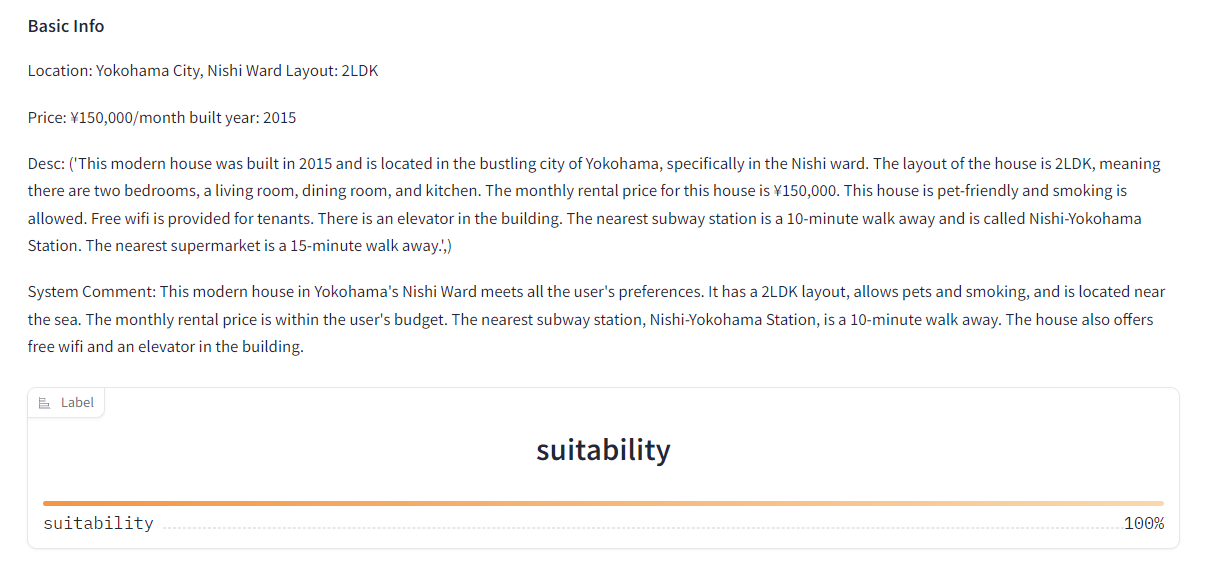

As the user want to live

    - I can only afford no more than 150,000 yen/month
    - I want live near the sea.
    - I want no bigger than 2LDK.
    - I want to walk into nearest subway station in 8 minutes.
    - I hate noise but want to live in downtown area for time saving.  Allowed pet and smoking is better.

we merge the user preference first, and ask rag system to find some house align with this preference,
the LanceDB return the RAG result like

```
=============

1.
'This modern house was built in 2017 and is located in the Nishi Ward of Yokohama. It has a spacious 2LDK layout, perfect for small families or couples. The rental price is ¥150,000 per month. Pets are allowed and smoking is not permitted. Free wifi is provided and there is an elevator available in the building. It takes 10 minutes to walk to the nearest subway station, Kannai Station, and there is a nearby supermarket that can be reached in 5 minutes by foot.', 'name': 'Modern Yokohama House', 'year': '2017', 'location': 'Yokohama, Nishi Ward', 'layout': '2LDK', 'price': '¥150,000/month'
=============

2. 
'This modern house was built in 2015 and is located in the bustling city of Chiba. It features a spacious 1LDK layout, perfect for individuals or couples. The rental price is ¥120,000 per month and includes free wifi. Pets and smoking are not allowed. There is an elevator in the building and it takes 10 minutes to walk to the nearest subway station, Chiba Station. It also only takes 5 minutes to walk to the nearest supermarket, making grocery shopping quick and convenient.', 'name': 'Cozy Chiba House', 'year': '2015', 'location': 'Chiba City, Chuo Ward', 'layout': '1LDK', 'price': '¥120,000/month'
=============

3.
'This modern house was built in 2015 and is located in the bustling city of Yokohama, specifically in the Nishi ward. The layout of the house is 2LDK, meaning there are two bedrooms, a living room, dining room, and kitchen. The monthly rental price for this house is ¥150,000. This house is pet-friendly and smoking is allowed. Free wifi is provided for tenants. There is an elevator in the building. The nearest subway station is a 10-minute walk away and is called Nishi-Yokohama Station. The nearest supermarket is a 15-minute walk away.', 'name': 'Modern House in Yokohama', 'year': '2015', 'location': 'Yokohama City, Nishi Ward', 'layout': '2LDK', 'price': '¥150,000/month'
Then we compose a prompt by assert the rag returned context with user preference together, asking llm return the ranking ans a score of suitability.
```

In the prompt,
 
    1. First, I ask the llm first filter house which montly rental fee is higher than user's budget. which remove the 1 and 4.
    2. Second, I ask the llm to evaluate user preference one by one and score the suitability of that house. then add details comment
    to explain which point is statisfied, and which is not.
    3. At Last, I require the LLM to return the best 2 result with the suitability score.

By doing this, we find the best house match the users preference